In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib notebook

In [2]:
df = pd.read_csv("people_wiki.csv")

In [3]:
df.head()


,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


I'll use TfidfVectorizer from sklearn.
It uses bit different cost function: $\log \frac{1+n_d}{1+df(n, t)} + 1$ instead of $\log \frac{n_d}{1+df(n, t)}$ like was described in lecture.

Also this class produces $n\times m$ *sparse*-matrix as output, where n - count of docs in corpus; m - count of all words in all docs and (i, j) element in matrix contains tfidf score for m'th word in n'th doc

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer="word", stop_words="english", token_pattern="[a-zA-Z]+")
out = tfidf.fit_transform(df.text)


In [6]:
print type(out)
print "Out size: ", out.shape

<class 'scipy.sparse.csr.csr_matrix'>
Out size:  (59071, 499560)


From out size I see that there are 499560 different words in our corpus.

Scipy csr matrix used for storing sparce matrices. Most part of this matrix is zero. Such matrices stores in memory like set of tuples (index1, index2, value). It allows to efficiently use memory, but you will limited in other operations like iterate over rows and so on. (Because for getting row you will need O(m) operations to construct array).

Details here: https://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html

Below I give an example hoy you can work with such matrices. **row_to_words** is function, which gets row from **out** matrix for n-th doc and returns list of [word, tfIdf of this word for n-th doc]

In [11]:
# get array of words. This array have same order what in out matrix columns.
tfidf_labels = tfidf.get_feature_names()

import itertools
from collections import OrderedDict

def row_to_words(row):
    return [
        [tfidf_labels[j], row[i, j]]
        for i, j in itertools.izip(*row.nonzero())
    ]

d = row_to_words(out.getrow(df[df.name == "Barack Obama"].index[0]))
    
print "Top 10 tfidf words for Obama:"
sorted(d, key=lambda i: -i[1])[:10]
    
    

Top 10 tfidf words for Obama:


[[u'obama', 0.45920218262664508],
 [u'act', 0.28198939360099662],
 [u'iraq', 0.17189760153750611],
 [u'law', 0.163858500374396],
 [u'control', 0.14934525449954991],
 [u'ordered', 0.13861075526118874],
 [u'military', 0.13534634127311537],
 [u'democratic', 0.12977127063030808],
 [u'involvement', 0.12480151707232458],
 [u'response', 0.12477308655231617]]

<IPython.core.display.Javascript object>


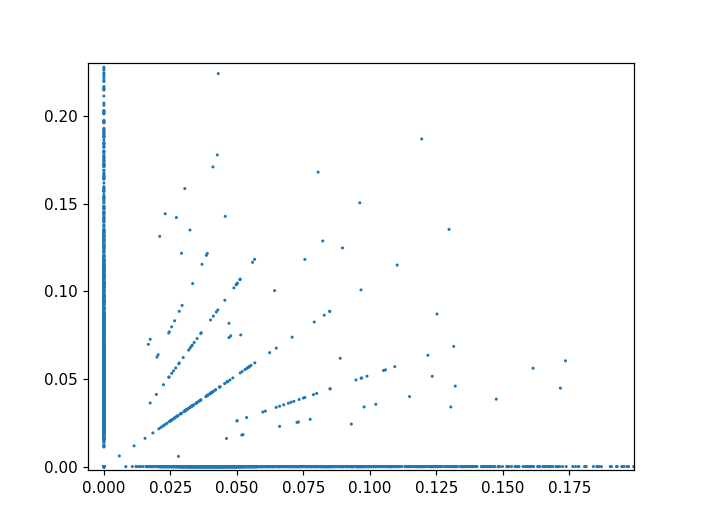

In [70]:
# For interest, let's plot first 100 docs in axis: (tdidf for word obama, tfidf for word response)

idfs = np.hstack([
    out.getcol(tfidf_labels.index("democratic")).toarray(), 
    out.getcol(tfidf_labels.index("military")).toarray()
])

plt.scatter(
    idfs[:, 0], 
    idfs[:, 1],
    s=[1]*out.shape[0]
)


There is interesint cluster where weight of democratic equals to weight of military. look on them:

<IPython.core.display.Javascript object>


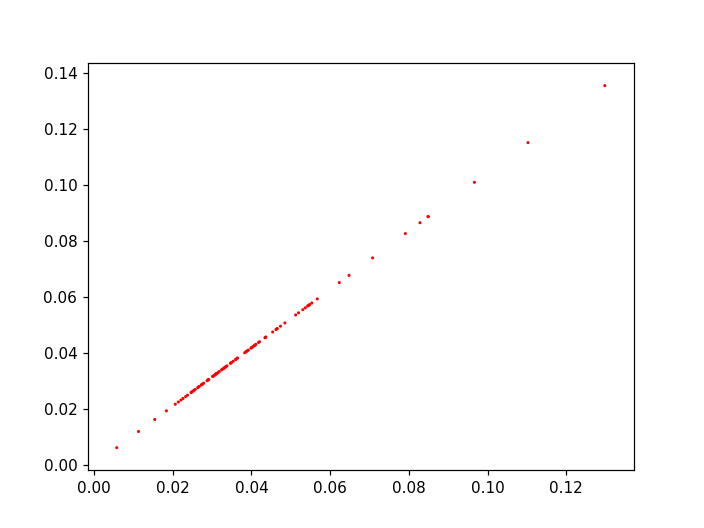

In [72]:
centerRowIndexes = np.where((np.abs(idfs[:, 1]-idfs[:, 0]) < 0.01) & (idfs[:, 1] > 0))[0]
centerCluster = idfs[centerRowIndexes, :]

plt.scatter(
    centerCluster[:, 0], centerCluster[:, 1], color="red", s=[1]*centerCluster.shape[0]
)

In [80]:
names = []
for idx in centerRowIndexes:
    names.append([
        df.iloc[idx]["name"], idfs[idx, 0]
    ])

sorted(names, key=lambda i: -i[1])[:20]
    

[['Barack Obama', 0.12977127063030808],
 ['Omoniyi Caleb Olubolade', 0.11025991840582318],
 ['William R. Hawkins', 0.0966587338080271],
 ['Mikola Statkevich', 0.084913997464316479],
 ['Andrew A. Michta', 0.084901551418223933],
 ['Johnny Chung', 0.082832754456848942],
 ['Jos%C3%A9 R. Rodr%C3%ADguez', 0.079102383250100841],
 ['Sam Ewang', 0.070790703243177447],
 ['Ben Ncube', 0.064809582961506296],
 ['Saidu Kumo', 0.062330023745061219],
 ['Margaret Levi', 0.056736758463376176],
 ['Pavel Baev', 0.055338416980562063],
 ['Khairat Abdulrazaq-Gwadabe', 0.054775660251602118],
 ['Selmo Cikoti%C4%87', 0.054596599444392567],
 ['Bonnie Korzeniowski', 0.054483149491792247],
 ['Geir J%C3%B8rgen Bekkevold', 0.054298309233214895],
 ['Abdulwahab Hussain', 0.0536943574908849],
 ['Marc L. Marks', 0.053056318282059603],
 ['%C3%89laine Michaud', 0.051979707517361605],
 ['Rand Paul', 0.051241439202389848]]

We see that words and tfidf are similar to ones from lecture. I think the difference because of different tfidf realizations in sklearn and graphlab packages.

### Compute distance between Obama and Clinton, Obama and Beckham

In [118]:
from sklearn.metrics.pairwise import cosine_distances

cosine_distances(
    out.getrow(df[df.name == "Barack Obama"].index[0]), 
    out.getrow(df[df.name == "Bill Clinton"].index[0]), 
)


array([[ 0.81792052]])

In [119]:
cosine_distances(
    out.getrow(df[df.name == "Barack Obama"].index[0]), 
    out.getrow(df[df.name == "David Beckham"].index[0]), 
)


array([[ 0.98126801]])

The results are pretty similar to lecture ones (0.834 and 0.979)

### Build a nearest neighbor model for doc retrieval


In [7]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=30)
nn.fit(out)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=30, p=2, radius=1.0)

#### nearest obama articles

In [8]:
obamaIndex = df[df.name == "Barack Obama"].index[0]
distances, indexes = nn.kneighbors(out.getrow(obamaIndex))

for i, idx in enumerate(indexes[0]):
    print df.iloc[idx]["name"], distances[0][i]


Barack Obama 0.0
Joe Biden 0.672288321092
Samantha Power 0.714418000188
Eric Stern (politician) 0.739533120401
Hillary Rodham Clinton 0.74134296493
Robert Gibbs 0.758607908757
Eric Holder 0.764621203484
Jesse Lee (politician) 0.766395952586
Henry Waxman 0.769307018325
Joe the Plumber 0.771214124212
Kenneth D. Thompson 0.787025325376
Phil Schiliro 0.787182127489
Artur Davis 0.788006856792
Jeff Sessions 0.790957128529
John D. McCormick 0.791192493924
John McCain 0.793017581256
George W. Bush 0.801187167907
Joe Walsh (Illinois politician) 0.805987012595
John C. Eastman 0.80614158397
Juan F. Vasquez 0.807586340074
Elizabeth Warren 0.810121278284
John G. Levi 0.810574977719
Richard Pildes 0.813369706196
Jonathan Alter 0.815332424097
Edward B. Montgomery 0.815377122186
Mitt Romney 0.81544684383
John Kerry 0.816181068978
Bill Clinton 0.817920523427
Lawrence Summers 0.820015111372
Douglas Schoen 0.820790295587


In [9]:
distances, indexes = nn.kneighbors(out.getrow(df[df.name == "Taylor Swift"].index[0]))

for i, idx in enumerate(indexes[0]):
    print df.iloc[idx]["name"], distances[0][i]

Taylor Swift 0.0
Carrie Underwood 0.695629107427
Al Swift 0.696555765953
Ed Sheeran 0.710345636588
Tim McGraw 0.710375178814
Bill Swift 0.711289363953
Kelly Clarkson 0.712746698122
Adele 0.716337260898
Joss Stone 0.720014783548
Dolly Parton 0.720409457809
Ricky Martin 0.725731613824
Miranda Lambert 0.729564646769
Faith Hill 0.738573638174
Andrea Bocelli 0.739365089555
Keith Urban 0.744614925879
George Strait 0.747805373468
Amy Grant 0.748065800599
JoJo (singer) 0.749286414304
Pink (singer) 0.749506488419
Alicia Keys 0.749720544121
Billy Ray Cyrus 0.754705266654
Usher (entertainer) 0.756020408005
George Michael 0.757632071266
Toni Braxton 0.759199736166
Will.i.am 0.759487834853
Andrea Bocelli discography 0.759735705133
Anne Murray 0.759952231509
Lady Gaga 0.762367448102
Rihanna 0.763808979781
Randy Travis 0.765128791259


In [10]:
distances, indexes = nn.kneighbors(out.getrow(df[df.name == "Arnold Schwarzenegger"].index[0]))

for i, idx in enumerate(indexes[0]):
    print df.iloc[idx]["name"], distances[0][i]

Arnold Schwarzenegger 1.11022302463e-16
Bonnie Garcia 0.779002865163
Paul Grant (bodybuilder) 0.788508773957
James Tramel 0.814599988183
Abel Maldonado 0.815401576381
Gray Davis 0.820103765181
Bruce McPherson 0.828601541693
Charlene Zettel 0.832077288072
David Israel 0.841099704207
Peter Pilz 0.842372358736
Russell Gould 0.842870905751
Hal Lieberman 0.849977405038
Patrick Johnston (American politician) 0.853963361494
Mike Katz 0.854959038583
Art Olivier 0.854999827104
Jerry Brown 0.861688553827
John Garamendi 0.865687850139
Barbara Becnel 0.867148153802
George Butler (filmmaker) 0.871358188079
Ted Gray (politician) 0.87782621785
Olene S. Walker 0.878729707191
David Crane (politics) 0.881540197874
Jusup Wilkosz 0.881879581557
Nikki Haley 0.884474772959
Anthony Adams (politician) 0.885758106671
Cathy Mitchell 0.885802072122
Erik Fankhouser 0.886863188647
Matthew Krok 0.887101338678
Rick Perry 0.887103588387
Harrison Ford 0.888090885186
